### Import Required Libraries and Set Up Environment Variables

In [50]:
!pip install fredapi
!pip install prophet

In [51]:
# Dependencies
# Clean up and delete the import that is not required
import numpy as np
import requests
import time
# from dotenv import load_dotenv
import os
import pandas as pd
import json
import os
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import seaborn as sns
from prophet import Prophet

# load_dotenv()

# from fredapi is a library that provides functionality to interact with the
# FRED (Federal Reserve Economic Data).
# import Fred imports the Fred class (or function) from the fredapi module.
# The fred variable can call methods defined in the Fred class to access
# economic data from the FRED API.


from fredapi import Fred

#### The US dollar (USD) to Mexican peson (MXN) foreign exchange rate.
#### Imagine you are an American going on a vacation to Mexico in three months.   
#### You can exchange your hard earned USD to MXN now or wait until you arrive
#### in Mexico. This project will help you to make an informed decision.  Better
#### yet, you can then learn to apply this methodology when you travel to other
#### foreign countries.

### Access Fred data using api_key

In [3]:
# Initializes a new object of the Fred class and assigns it to the variable
# fred.
# This api_key is used for authentication when making requests to the
# FRED (Federal Reserve Economic Data) API.
# Later need to store the api_key in .env
# FRED is a free and reliable government data source.

fred = Fred(api_key="76b3e944bbc0ad36e888dff895f8c750")


In [4]:
# Fetch data using fred.get_series().

# Use variable to store startd_date
start_date = "2010-01-01"

# Exchange rate: $1 equals Mexican pesos
exchange_rate = fred.get_series("DEXMXUS", start=start_date)

# U.S. fed rate
fed_rate = fred.get_series("FEDFUNDS", start=start_date)

# U.S. 90-days T-bill rate
t_bill_rate = fred.get_series('TB3MS', start=start_date)

# Mexico 90-days T-bill rate
mx_t_bill_rate = fred.get_series('INTGSTMXM193N', start=start_date)

# U.S. Real GDP, adjusted for inflation
us_gdp = fred.get_series('GDPC1', start=start_date)

# Mexico Real GDP, adjusted for inflation
mx_gdp = fred.get_series('NGDPRSAXDCMXQ', start=start_date)


### Create master DataFrame containing all data.

In [5]:
# Select series from https://fred.stlouisfed.org/series

# Combine data into a DataFrame.  This is the main DF.
# Each time series has different start date and availability (daily vs
# monthly).  Note: markets closed on holidays and weekends.
data = pd.DataFrame({
                    'Exchange Rate': exchange_rate,
                    'Fed Rate': fed_rate,
                    'US 90-Day T-bill': t_bill_rate,
                    'MX 90-Day T-bill': mx_t_bill_rate,
                    'US Real GDP': us_gdp,
                    'MX Real GDP': mx_gdp
                    })

In [6]:
# Using shape to get the dimension of the DataFrame.
data.shape

(8909, 6)

In [7]:
# Get the start and end date for each time series in data.
# It is important to have same start and end dates when comparing data.

exchange_rate_series = fred.get_series("DEXMXUS")
print(f"The foreign exchange rate start and end dates: {exchange_rate_series.index.min().strftime('%Y-%m-%d')} \
to {exchange_rate_series.index.max().strftime('%Y-%m-%d')}")

fed_rate_series = fred.get_series("FEDFUNDS")
print(f"The US Fed Rate start and end dates: {fed_rate_series.index.min().strftime('%Y-%m-%d')} \
to {fed_rate_series.index.max().strftime('%Y-%m-%d')}")

t_bill_rate_series = fred.get_series("DTB3")
print(f"The US 90-Day T-bill start and end dates: {t_bill_rate_series.index.min().strftime('%Y-%m-%d')} \
to {t_bill_rate_series.index.max().strftime('%Y-%m-%d')}")

exchange_rate_series = fred.get_series("TB3MS")
print(f"The Mexico 90-Day T-bill start and end dates: {exchange_rate_series.index.min().strftime('%Y-%m-%d')} \
to {exchange_rate_series.index.max().strftime('%Y-%m-%d')}")

us_gdp_series = fred.get_series("GDP")
print(f"The US GDP start and end dates: {us_gdp_series.index.min().strftime('%Y-%m-%d')} \
to {us_gdp_series.index.max().strftime('%Y-%m-%d')}")

mx_gdp_series = fred.get_series("NGDPRSAXDCMXQ")
print(f"The Mexican GDP start and end dates: {mx_gdp_series.index.min().strftime('%Y-%m-%d')} \
to {mx_gdp_series.index.max().strftime('%Y-%m-%d')}")



The foreign exchange rate start and end dates: 1993-11-08 to 2024-11-01
The US Fed Rate start and end dates: 1954-07-01 to 2024-10-01
The US 90-Day T-bill start and end dates: 1954-01-04 to 2024-11-07
The Mexico 90-Day T-bill start and end dates: 1934-01-01 to 2024-10-01
The US GDP start and end dates: 1946-01-01 to 2024-07-01
The Mexican GDP start and end dates: 1993-01-01 to 2024-04-01


In [8]:
# Preview data
# why above US GDP has value for 1946-01-01 but below no value for 1946-01-01
# Exchange Rate nad US on daily basis when market is opened.  Other data
# is based on different time interval (monthly, quarterly)
# Note: 1946-01-01 is default if start_date out of range.
data.tail(50)

,Exchange Rate,Fed Rate,US 90-Day T-bill,MX 90-Day T-bill,US Real GDP,MX Real GDP
2024-08-27,19.6486,NaN,NaN,NaN,NaN,NaN
2024-08-28,19.5288,NaN,NaN,NaN,NaN,NaN
2024-08-29,19.7880,NaN,NaN,NaN,NaN,NaN
2024-08-30,19.6576,NaN,NaN,NaN,NaN,NaN
2024-09-01,NaN,5.13,4.72,NaN,NaN,NaN
2024-09-02,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-03,19.8300,NaN,NaN,NaN,NaN,NaN
2024-09-04,19.8161,NaN,NaN,NaN,NaN,NaN
2024-09-05,19.9926,NaN,NaN,NaN,NaN,NaN
2024-09-06,20.0399,NaN,NaN,NaN,NaN,NaN


In [9]:
# Use dtpes to check data types
print(data.dtypes)
print(data.index)

Exchange Rate       float64
Fed Rate            float64
US 90-Day T-bill    float64
MX 90-Day T-bill    float64
US Real GDP         float64
MX Real GDP         float64
dtype: object
DatetimeIndex(['1934-01-01', '1934-02-01', '1934-03-01', '1934-04-01',
               '1934-05-01', '1934-06-01', '1934-07-01', '1934-08-01',
               '1934-09-01', '1934-10-01',
               ...
               '2024-10-21', '2024-10-22', '2024-10-23', '2024-10-24',
               '2024-10-25', '2024-10-28', '2024-10-29', '2024-10-30',
               '2024-10-31', '2024-11-01'],
              dtype='datetime64[ns]', length=8909, freq=None)


### Welcome.  Congratulations and latest USD to MXN foreign exchange.

### Create Foreign Exchange DataFrame from Original DataFrame

In [10]:
# Select the Date and Exchange Rate columns and store in data_fx
# Only interested in the USD to MX Peso exchange rate for now.
# Use dropna() to select dates with available Exchange Rate
# Obtain the longest time series for Exchange Rate
data_fx = data[['Exchange Rate']]
# set_index so Date prints on the x-axis when graphing.
# data_fx = data_fx.set_index('Date')
data_fx

,Exchange Rate
1934-01-01,NaN
1934-02-01,NaN
1934-03-01,NaN
1934-04-01,NaN
1934-05-01,NaN
...,...
2024-10-28,20.0444
2024-10-29,20.0000
2024-10-30,20.1720
2024-10-31,20.0314


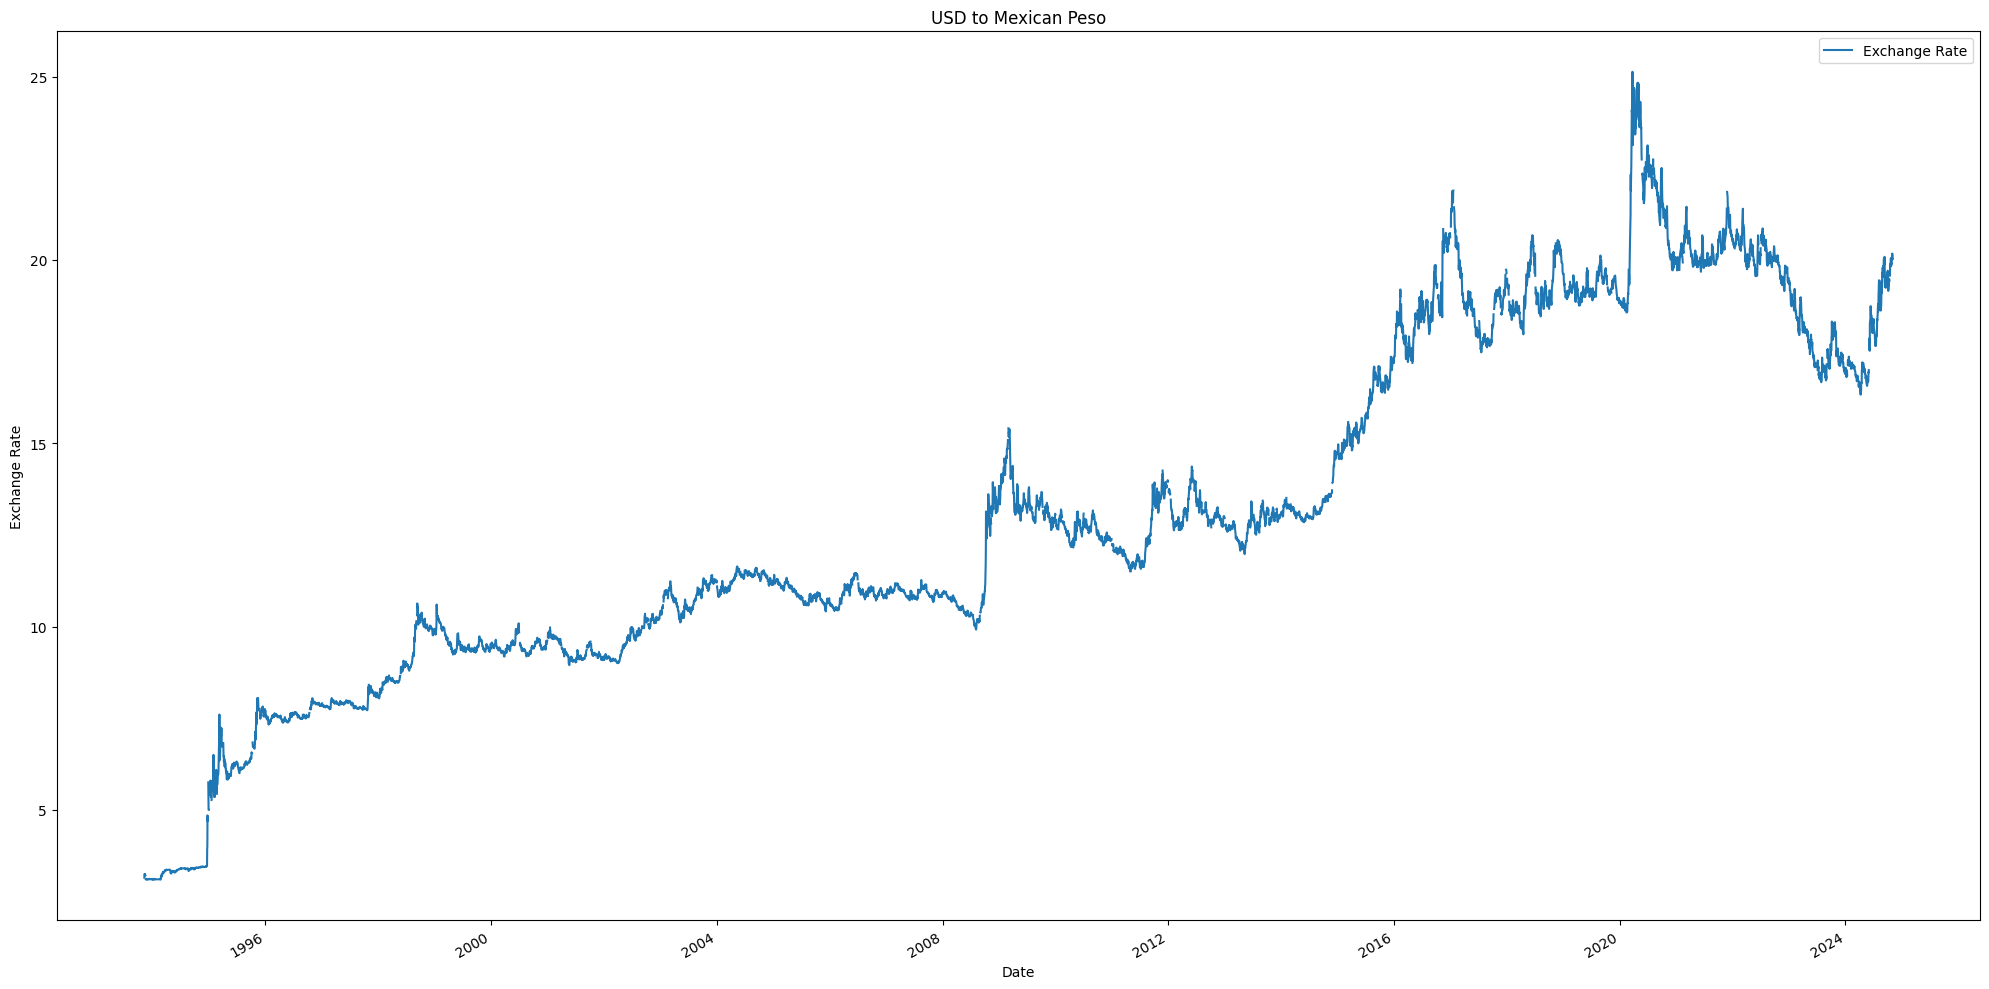

In [11]:
# Plot the Exchange Rate.  Provide title and label x and y-axis labels.
# When the USD to Peso exchange rate increases, the USD appreciates.
# When the USD to Peso exchange rate decreases, the USD depreciates.
# Note the time short time periods when USD appreciates dramaticlly.
# There is an upward trend in USD appreciation against the MXN in the
# past 30 years.

data_fx.plot(title='USD to Mexican Peso', figsize=(20, 10))
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.tight_layout()
plt.show()

### Calculate and plot regression line.

In [16]:
#Check type of Exchange Rate column
print(data_fx["Exchange Rate"].dtype)

float64


In [17]:
# drop null values
data_fx = data_fx.dropna()

In [18]:
# Calculate the y = mx +b line in above graph.  Show calculation and plot the regression line.
# already performed: from scipy import stats and import matplotlib.pyplot as plt

# Perform linear regression
# Convert the index to a numerical format
x = data_fx.index.map(pd.Timestamp.toordinal).values
y = data_fx["Exchange Rate"].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

In [19]:
# Calculate the predicted y values
regression_line = slope * x + intercept

dates = pd.to_datetime(data_fx.index)

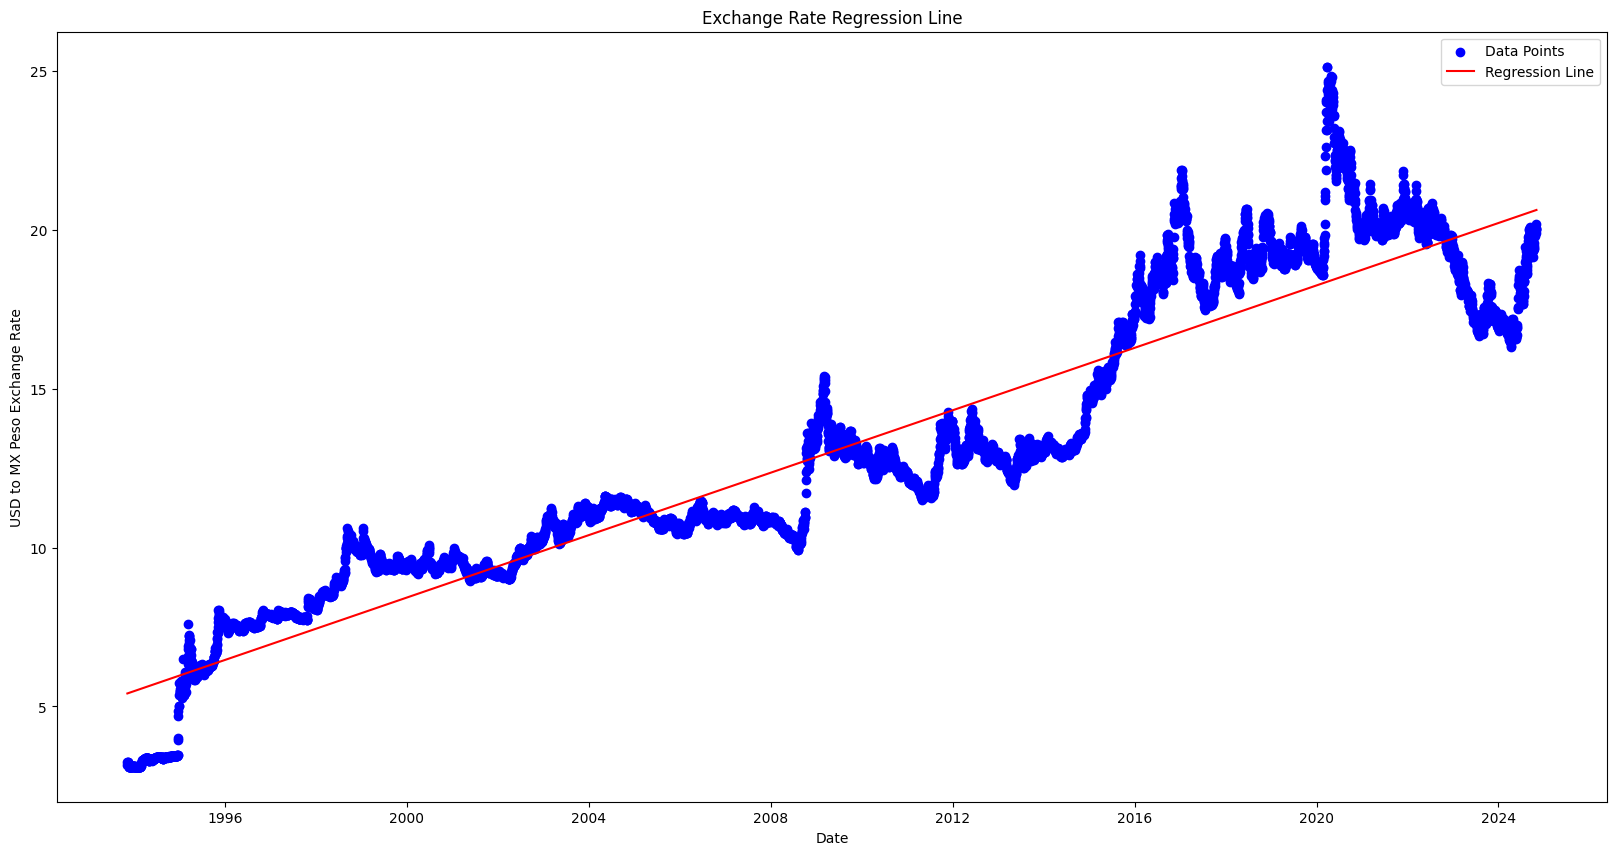

(0.001344618226416253, -973.3058387164346)

In [20]:
# Plotting
plt.figure(figsize=(20,10))
plt.scatter(data_fx.index, y, label="Data Points", color="blue")
plt.plot(data_fx.index, regression_line, color="red", label="Regression Line")
plt.xlabel("Date")
plt.ylabel("USD to MX Peso Exchange Rate")
plt.title("Exchange Rate Regression Line")
plt.legend()
plt.show()

slope, intercept



In [21]:
# This simple regression line is based on everything else the same.
# Convert the last day to ordinal
x_current = data_fx.index[-1].toordinal()

In [22]:
# Calculate the x value for 90 days later
x_90_days_later = x_current + 90

In [23]:
# Print slope and intercept values
print(slope)
print(intercept)

0.001344618226416253
-973.3058387164346


In [24]:
# Calaculate the predicted y value (USD to MXN foreign exchange rate)
predicted_y = slope * x_90_days_later + intercept


In [25]:
# Cannot be negataive number
print(f"Predicted value in 90 days: {predicted_y}")

Predicted value in 90 days: 20.744868326799406


### The USD is considered a safe haven during times of economic turmoil.


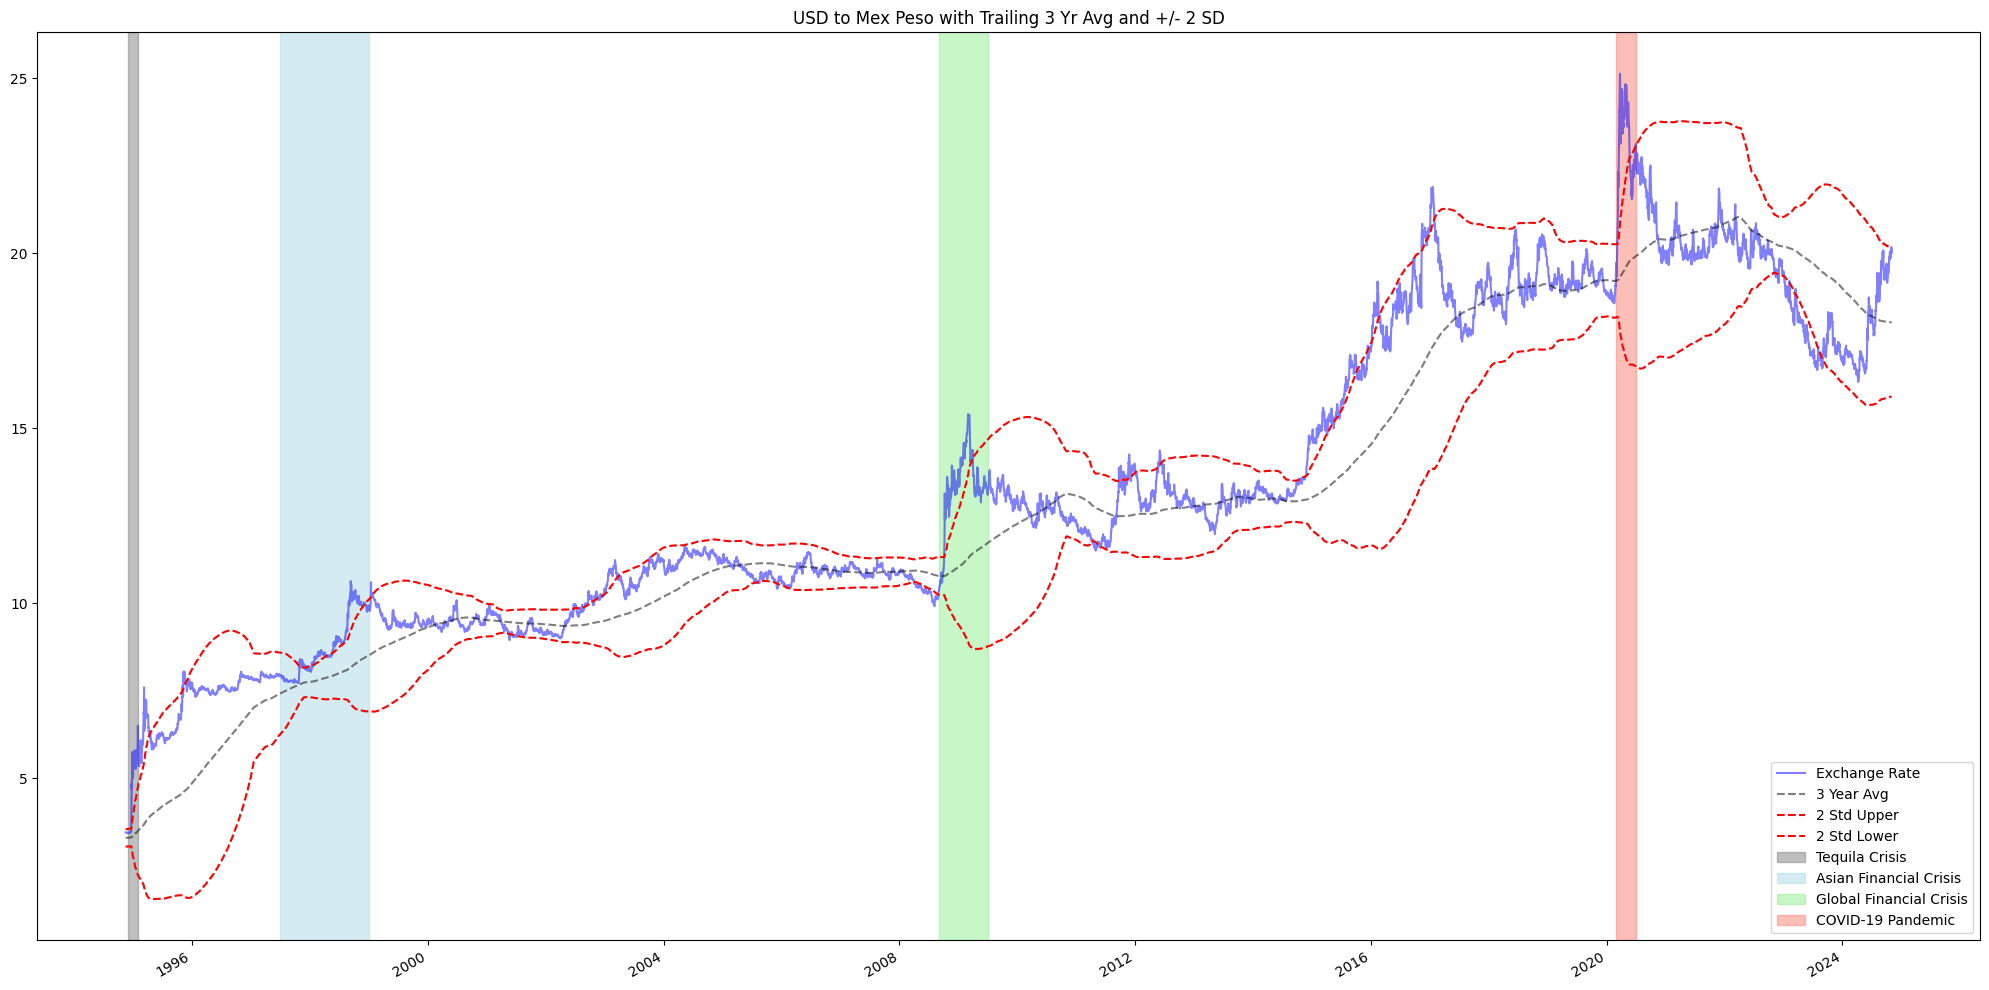

In [41]:
# for loop for each row, set start_date 756 days or 3 years back.
# if data_3_year retrieves 3 years data
# need to adjust if any data is NaN
# Create the average and +/- 2 SD (standard deviation)

plt.figure(figsize=(20, 10))

for row_date in data_fx.index:
    start_date = row_date - pd.DateOffset(days=756)  # Look back 756 days
    data_3_year = data_fx.loc[start_date:row_date, 'Exchange Rate']

    # why not return False or empty for the first three years
    if not data_3_year.empty:
        avg = data_3_year.mean()
        std = data_3_year.std()

        # Assign the computed values using loc
        data_fx.loc[row_date, '1_year_avg'] = avg
        data_fx.loc[row_date, '2_std_upper'] = avg + 2 * std
        data_fx.loc[row_date, '2_std_lower'] = avg - 2 * std

# Filter data to remove empty rows from the first three years.
filtered_data = data_fx.dropna(subset=['1_year_avg', '2_std_upper', '2_std_lower'])

# For 3 year trailing average, forward 3 years or 756 days
filtered_data = data_fx[data_fx.index >= data_fx.index[251]]

# Filter for dates starting from 1997 - Need to verify
#filtered_data = filtered_data[filtered_data.index >= pd.Timestamp('1997-01-01')]

# Plotting: calculate current, 3 year moving average, and +/- 2 SD
filtered_data['Exchange Rate'].plot(label='Exchange Rate', color='blue', alpha=0.5)
filtered_data['1_year_avg'].plot(label='3 Year Avg', color='black', linestyle="--", alpha=0.5)
filtered_data['2_std_upper'].plot(label='2 Std Upper', color='red', linestyle='--')
filtered_data['2_std_lower'].plot(label='2 Std Lower', color='red', linestyle='--')

# Major economic events effecting USD to MXN exchanage rate
plt.axvspan(pd.Timestamp('1994-12-01'), pd.Timestamp('1995-01-31'), color='grey', alpha=0.5, label='Tequila Crisis')
plt.axvspan(pd.Timestamp('1997-07-01'), pd.Timestamp('1998-12-31'), color='lightblue', alpha=0.5, label='Asian Financial Crisis')
plt.axvspan(pd.Timestamp('2008-09-01'), pd.Timestamp('2009-06-30'), color='lightgreen', alpha=0.5, label='Global Financial Crisis')
plt.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-06-30'), color='salmon', alpha=0.5, label='COVID-19 Pandemic')

 # Label and plot
# plt.figure(figsize=(20, 10))
plt.title('USD to Mex Peso with Trailing 3 Yr Avg and +/- 2 SD')
plt.legend()
plt.tight_layout()
plt.show()

# If all the code in one panel or cell, it works.
# How to fix this problem

### Correlation

In [42]:

data

,Exchange Rate,Fed Rate,US 90-Day T-bill,MX 90-Day T-bill,US Real GDP,MX Real GDP
1934-01-01,NaN,NaN,0.72,NaN,NaN,NaN
1934-02-01,NaN,NaN,0.62,NaN,NaN,NaN
1934-03-01,NaN,NaN,0.24,NaN,NaN,NaN
1934-04-01,NaN,NaN,0.15,NaN,NaN,NaN
1934-05-01,NaN,NaN,0.16,NaN,NaN,NaN
...,...,...,...,...,...,...
2024-10-28,20.0444,NaN,NaN,NaN,NaN,NaN
2024-10-29,20.0000,NaN,NaN,NaN,NaN,NaN
2024-10-30,20.1720,NaN,NaN,NaN,NaN,NaN
2024-10-31,20.0314,NaN,NaN,NaN,NaN,NaN


In [43]:
quarterly_avg = data.resample('Q').mean()
quarterly_avg

<ipython-input-43-0458cfa85e24>:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_avg = data.resample('Q').mean()


,Exchange Rate,Fed Rate,US 90-Day T-bill,MX 90-Day T-bill,US Real GDP,MX Real GDP
1934-03-31,NaN,NaN,0.526667,NaN,NaN,NaN
1934-06-30,NaN,NaN,0.153333,NaN,NaN,NaN
1934-09-30,NaN,NaN,0.183333,NaN,NaN,NaN
1934-12-31,NaN,NaN,0.250000,NaN,NaN,NaN
1935-03-31,NaN,NaN,0.180000,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-12-31,17.545556,5.330000,5.283333,11.060000,22960.600,6300104.5
2024-03-31,16.983616,5.330000,5.233333,11.120000,23053.545,6306870.5
2024-06-30,17.222032,5.330000,5.243333,10.976667,23223.906,6316702.0
2024-09-30,18.924516,5.263333,4.990000,10.840000,23386.248,NaN


In [44]:
quarterly_avg.dropna(inplace=True)
quarterly_avg

,Exchange Rate,Fed Rate,US 90-Day T-bill,MX 90-Day T-bill,US Real GDP,MX Real GDP
1993-12-31,3.123720,2.990000,3.060000,13.096667,10833.987,3513104.5
1994-03-31,3.182411,3.213333,3.243333,9.900000,10939.116,3548062.0
1994-06-30,3.345166,3.940000,3.986667,16.110000,11087.361,3628977.5
1994-09-30,3.395023,4.486667,4.476667,15.096667,11152.176,3649230.5
1994-12-31,3.618785,5.166667,5.280000,15.283333,11279.932,3688503.5
...,...,...,...,...,...,...
2023-06-30,17.689335,4.990000,5.073333,11.256667,22539.418,6257248.0
2023-09-30,17.054851,5.260000,5.290000,11.153333,22780.933,6303922.5
2023-12-31,17.545556,5.330000,5.283333,11.060000,22960.600,6300104.5
2024-03-31,16.983616,5.330000,5.233333,11.120000,23053.545,6306870.5


In [48]:
correlation_matrix = quarterly_avg.corr()
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print(correlation_matrix)

                  Exchange Rate  Fed Rate  US 90-Day T-bill  MX 90-Day T-bill  US Real GDP  MX Real GDP
Exchange Rate          1.000000 -0.529343         -0.506422         -0.508896     0.929682     0.898167
Fed Rate              -0.529343  1.000000          0.994867          0.691894    -0.474324    -0.508572
US 90-Day T-bill      -0.506422  0.994867          1.000000          0.686479    -0.448420    -0.488908
MX 90-Day T-bill      -0.508896  0.691894          0.686479          1.000000    -0.593637    -0.653261
US Real GDP            0.929682 -0.474324         -0.448420         -0.593637     1.000000     0.976914
MX Real GDP            0.898167 -0.508572         -0.488908         -0.653261     0.976914     1.000000


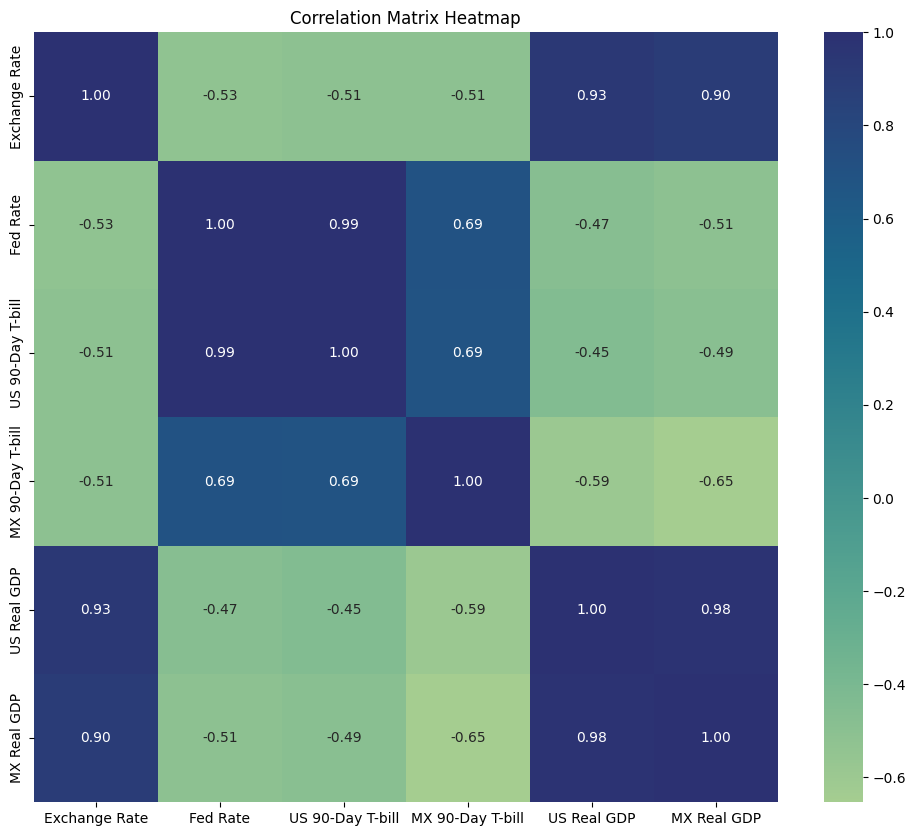

In [49]:
# Generate the heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='crest', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

### Interest Rate Parity (IRP). F = S x (1 + i US)/(1 + i MX).  
##### F is forward exchange rate, S is spot exchange rate (current), i US
##### is US 90 day T-bill and i MX is Mexico 90 day T-bill.
##### Example: F = 18 x (1.02) / (1.05) = 17.78
##### Everything else the same, the USD will depreciate vs MXN.

In [28]:
# Create a new DataFrame from the 'mother' DataFrame.  Use new variable.
data_irp = data[['Exchange Rate', 'US 90-Day T-bill', 'MX 90-Day T-bill']]

In [29]:
# US 90-Day T-bill is daily close; MX 90-Day T-bill is monthly average.
# Therefore, use quarterly average df.resample().mean()
monthly_avg_irp = data_irp.resample('M').mean()
monthly_avg_irp.dropna(inplace=True)
monthly_avg_irp

<ipython-input-29-c243b7005208>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_irp = data_irp.resample('M').mean()


,Exchange Rate,US 90-Day T-bill,MX 90-Day T-bill
1993-11-30,3.149792,3.10,14.38
1993-12-31,3.108314,3.06,11.78
1994-01-31,3.107785,2.98,10.52
1994-02-28,3.121763,3.25,9.45
1994-03-31,3.302632,3.50,9.73
...,...,...,...
2024-04-30,16.800809,5.24,10.97
2024-05-31,16.803277,5.25,10.99
2024-06-30,18.194637,5.24,10.97
2024-07-31,18.100173,5.20,10.92


In [30]:
monthly_avg_irp["Forward 90 Day Rate"] = monthly_avg_irp["Exchange Rate"] * \
                            ( 1 + monthly_avg_irp["US 90-Day T-bill"]/4/100) \
                            / (1 + monthly_avg_irp["MX 90-Day T-bill"]/4/100)

In [31]:
# Display data
monthly_avg_irp

,Exchange Rate,US 90-Day T-bill,MX 90-Day T-bill,Forward 90 Day Rate
1993-11-30,3.149792,3.10,14.38,3.064051
1993-12-31,3.108314,3.06,11.78,3.042491
1994-01-31,3.107785,2.98,10.52,3.050704
1994-02-28,3.121763,3.25,9.45,3.074493
1994-03-31,3.302632,3.50,9.73,3.252415
...,...,...,...,...
2024-04-30,16.800809,5.24,10.97,16.566562
2024-05-31,16.803277,5.25,10.99,16.568598
2024-06-30,18.194637,5.24,10.97,17.940956
2024-07-31,18.100173,5.20,10.92,17.848219


In [32]:
# Shift Forward 90 Day Rate 3 period forward or 90 days.
monthly_avg_irp["Forward 90 Day Rate Shifted"] = monthly_avg_irp["Forward 90 Day Rate"].shift(3)

In [33]:
# Show changes of shift
monthly_avg_irp

,Exchange Rate,US 90-Day T-bill,MX 90-Day T-bill,Forward 90 Day Rate,Forward 90 Day Rate Shifted
1993-11-30,3.149792,3.10,14.38,3.064051,NaN
1993-12-31,3.108314,3.06,11.78,3.042491,NaN
1994-01-31,3.107785,2.98,10.52,3.050704,NaN
1994-02-28,3.121763,3.25,9.45,3.074493,3.064051
1994-03-31,3.302632,3.50,9.73,3.252415,3.042491
...,...,...,...,...,...
2024-04-30,16.800809,5.24,10.97,16.566562,16.840889
2024-05-31,16.803277,5.25,10.99,16.568598,16.852049
2024-06-30,18.194637,5.24,10.97,17.940956,16.533452
2024-07-31,18.100173,5.20,10.92,17.848219,16.566562


In [34]:
# Calculate correlation matrix for only the "Exchange Rate" and "Forward 90 Day Rate" columns
correlation = monthly_avg_irp[['Exchange Rate', 'Forward 90 Day Rate Shifted']].corr()

# Display the correlation matrix
print(correlation)

                             Exchange Rate  Forward 90 Day Rate Shifted
Exchange Rate                     1.000000                     0.984506
Forward 90 Day Rate Shifted       0.984506                     1.000000


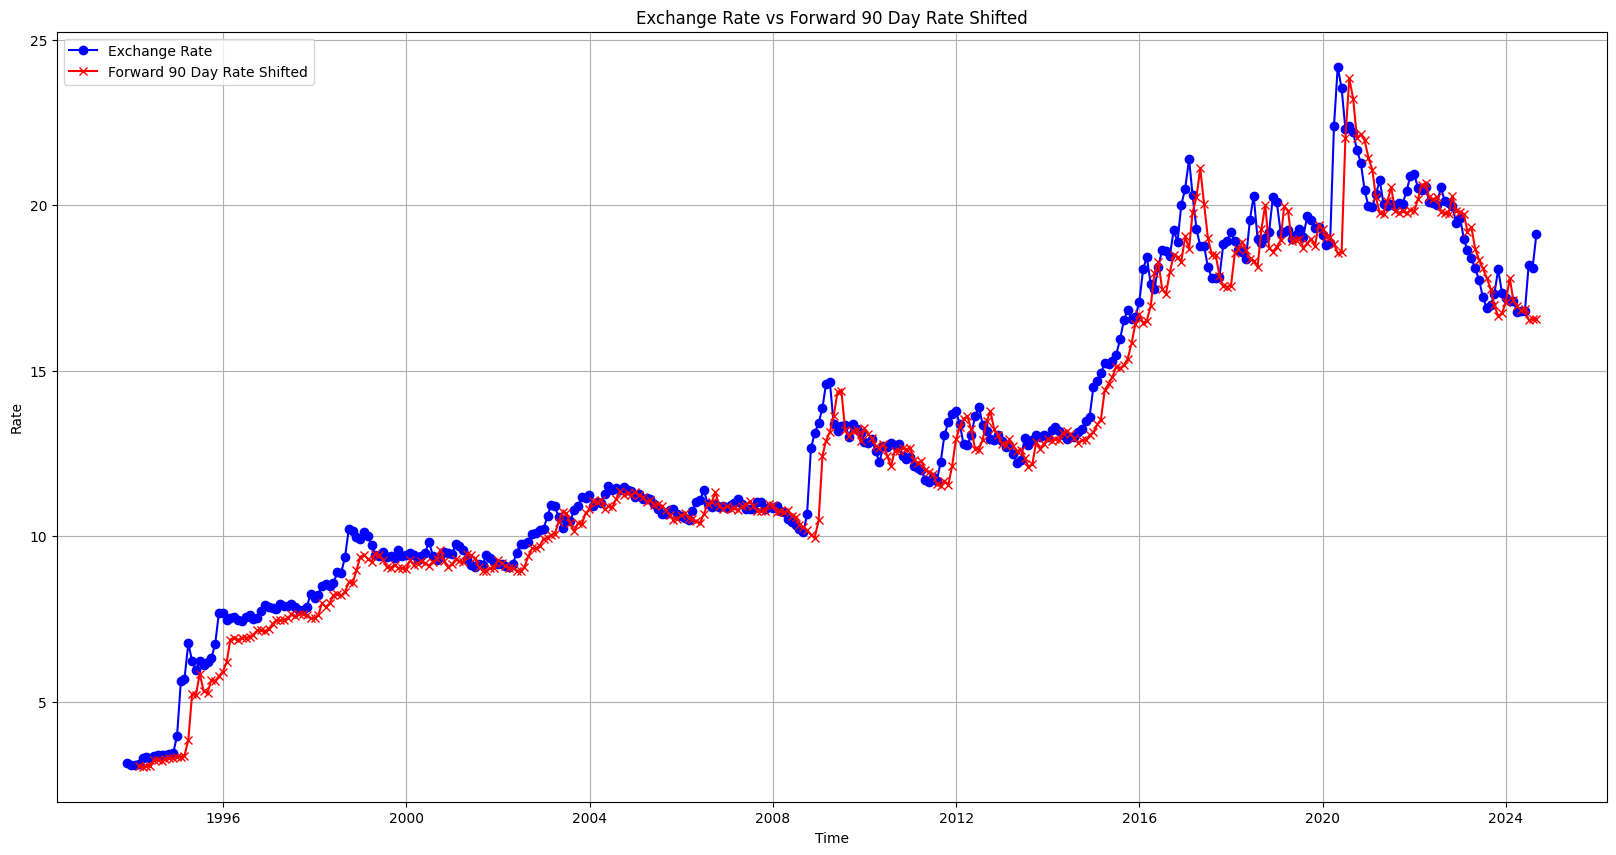

In [35]:
# Create the plot
plt.figure(figsize=(20, 10))  # Set the size of the plot

# Plot Exchange Rate
plt.plot(monthly_avg_irp.index, monthly_avg_irp['Exchange Rate'], label='Exchange Rate', marker='o', linestyle='-', color='b')

# Plot Forward 90 Day Rate Shifted
plt.plot(monthly_avg_irp.index, monthly_avg_irp['Forward 90 Day Rate Shifted'], label='Forward 90 Day Rate Shifted', marker='x', linestyle='-', color='r')

# Add labels and a title
plt.xlabel('Time')  # Label for x-axis
plt.ylabel('Rate')  # Label for y-axis
plt.title('Exchange Rate vs Forward 90 Day Rate Shifted')  # Title for the graph

# Add a legend to differentiate the lines
plt.legend()

# Optionally, add a grid for better visualization
plt.grid(True)

# Display the plot
plt.show()

### Prophet

In [79]:
# Check the shape of the data_fx dataframe
data_fx.shape

(7770, 4)

In [80]:
# Look at the last five rows in the dataframe
data_fx.tail()

,Exchange Rate,1_year_avg,2_std_upper,2_std_lower
2024-10-28,20.0444,18.028770,20.154769,15.902772
2024-10-29,20.0000,18.028707,20.154466,15.902947
2024-10-30,20.1720,18.029097,20.156357,15.901836
2024-10-31,20.0314,18.028951,20.155650,15.902251
2024-11-01,20.0273,18.028789,20.154867,15.902711


In [81]:
# Look at data_fx dataframe info
data_fx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7770 entries, 1993-11-08 to 2024-11-01
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Exchange Rate  7770 non-null   float64
 1   1_year_avg     7770 non-null   float64
 2   2_std_upper    7769 non-null   float64
 3   2_std_lower    7769 non-null   float64
dtypes: float64(4)
memory usage: 561.6 KB


In [82]:
# Create datframe with just Exchange Rate for use with Prophet
data_fx_for_prophet = data_fx['Exchange Rate']

In [84]:
# Display shape and info for new data_fx_for_prophet dataframe
display(data_fx_for_prophet.shape)
display(data_fx_for_prophet.info())

(7770,)

<class 'pandas.core.series.Series'>
DatetimeIndex: 7770 entries, 1993-11-08 to 2024-11-01
Series name: Exchange Rate
Non-Null Count  Dtype  
--------------  -----  
7770 non-null   float64
dtypes: float64(1)
memory usage: 379.4 KB


None

There are no null values in the dataframe

In [85]:
# Reset index so that data is no longer in the index and is a column
data_fx_for_prophet = data_fx_for_prophet.reset_index()

In [86]:
# Look at the last 5 rows in the dataframe to see the new column
data_fx_for_prophet.head()

,index,Exchange Rate
0,1993-11-08,3.152
1,1993-11-09,3.240
2,1993-11-10,3.240
3,1993-11-12,3.240
4,1993-11-15,3.215


In [87]:
# rename columns as required by Prophet
data_fx_for_prophet.columns = ['ds', 'y']

In [88]:
# Look at shape, first five rows and last five rows of dataframe
display(data_fx_for_prophet.shape)
display(data_fx_for_prophet.head())
display(data_fx_for_prophet.tail())

(7770, 2)

,ds,y
0,1993-11-08,3.152
1,1993-11-09,3.240
2,1993-11-10,3.240
3,1993-11-12,3.240
4,1993-11-15,3.215


,ds,y
7765,2024-10-28,20.0444
7766,2024-10-29,20.0000
7767,2024-10-30,20.1720
7768,2024-10-31,20.0314
7769,2024-11-01,20.0273


In [89]:
#Call the Prophet function, and stroe in a variable
model = Prophet()
model

In [90]:
# Fit the prophet model
model.fit(data_fx_for_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd6npmkti/2shn249u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd6npmkti/45z17zrb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45910', 'data', 'file=/tmp/tmpd6npmkti/2shn249u.json', 'init=/tmp/tmpd6npmkti/45z17zrb.json', 'output', 'file=/tmp/tmpd6npmkti/prophet_modelkw6nd7a_/prophet_model-20241110202056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:20:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:21:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [91]:
# Create a future dataframe to hold predictions
# Make the predictions go out as far as 70 days
future_trends = model.make_future_dataframe(periods=70, freq="B")
# Look at last 20 rows - verfiy that weekends are not included
future_trends.tail(20)

,ds
7820,2025-01-13
7821,2025-01-14
7822,2025-01-15
7823,2025-01-16
7824,2025-01-17
7825,2025-01-20
7826,2025-01-21
7827,2025-01-22
7828,2025-01-23
7829,2025-01-24


In [92]:
# Make the predictions for the trend data using the future trends DataFrame
forecast_trends = model.predict(future_trends)

# Display the first five rows of the forecast dataframe
forecast_trends.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
7835,2025-02-03,18.491230,17.419294,19.413603,18.491230,18.491230,-0.059505,-0.059505,-0.059505,-0.137743,-0.137743,-0.137743,0.078238,0.078238,0.078238,0.0,0.0,0.0,18.431725
7836,2025-02-04,18.490348,17.383422,19.367687,18.490348,18.490348,-0.062270,-0.062270,-0.062270,-0.136663,-0.136663,-0.136663,0.074393,0.074393,0.074393,0.0,0.0,0.0,18.428078
7837,2025-02-05,18.489466,17.356444,19.401312,18.489466,18.489466,-0.064850,-0.064850,-0.064850,-0.135132,-0.135132,-0.135132,0.070283,0.070283,0.070283,0.0,0.0,0.0,18.424616
7838,2025-02-06,18.488583,17.403035,19.471455,18.488583,18.488583,-0.068134,-0.068134,-0.068134,-0.134111,-0.134111,-0.134111,0.065977,0.065977,0.065977,0.0,0.0,0.0,18.420449
7839,2025-02-07,18.487701,17.425719,19.457018,18.487701,18.487701,-0.083402,-0.083402,-0.083402,-0.144958,-0.144958,-0.144958,0.061556,0.061556,0.061556,0.0,0.0,0.0,18.404299


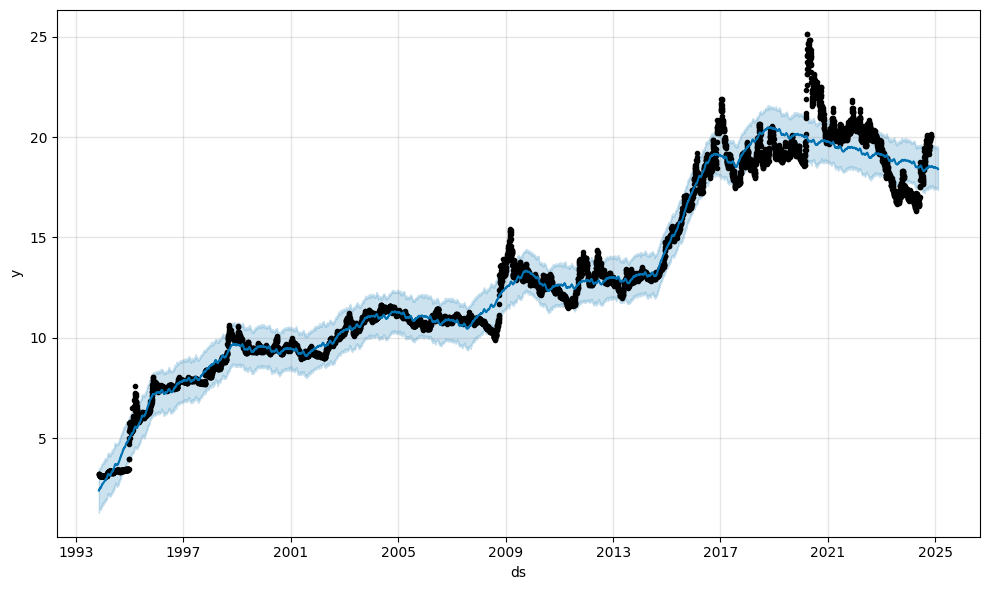

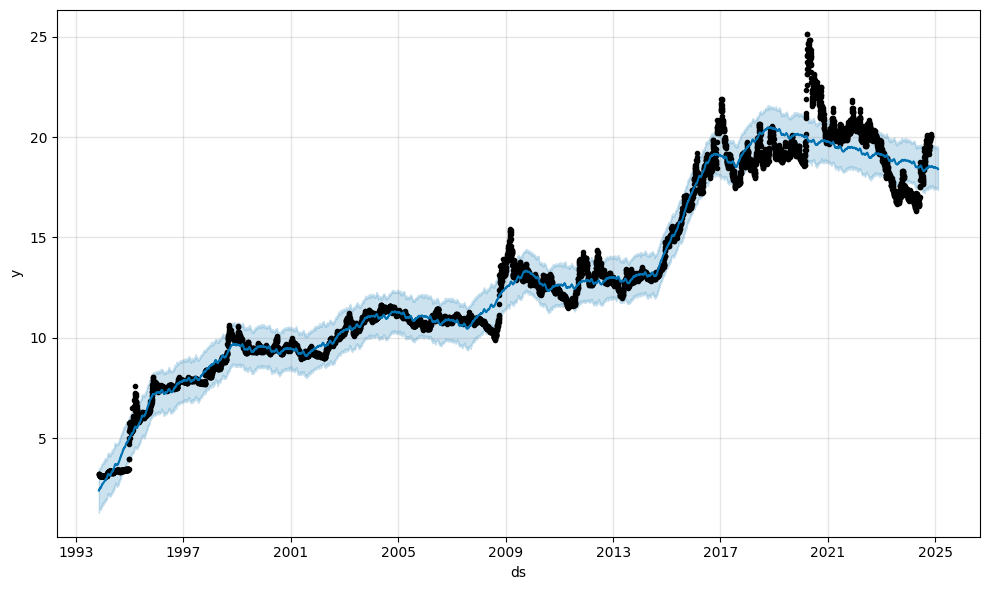

In [93]:
# Plot the Prophet predictions
model.plot(forecast_trends)

In [94]:
#Look at first five rows of forecast_trends dataframe
forecast_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1993-11-08,2.441227,1.295466,3.393400,2.441227,2.441227,-0.038989,-0.038989,-0.038989,-0.137743,-0.137743,-0.137743,0.098754,0.098754,0.098754,0.0,0.0,0.0,2.402238
1,1993-11-09,2.447441,1.478243,3.476105,2.447441,2.447441,-0.034061,-0.034061,-0.034061,-0.136663,-0.136663,-0.136663,0.102602,0.102602,0.102602,0.0,0.0,0.0,2.413379
2,1993-11-10,2.453655,1.461168,3.420854,2.453655,2.453655,-0.028858,-0.028858,-0.028858,-0.135132,-0.135132,-0.135132,0.106274,0.106274,0.106274,0.0,0.0,0.0,2.424797
3,1993-11-12,2.466082,1.486861,3.473350,2.466082,2.466082,-0.032184,-0.032184,-0.032184,-0.144958,-0.144958,-0.144958,0.112774,0.112774,0.112774,0.0,0.0,0.0,2.433898
4,1993-11-15,2.484723,1.475697,3.474906,2.484723,2.484723,-0.018330,-0.018330,-0.018330,-0.137743,-0.137743,-0.137743,0.119413,0.119413,0.119413,0.0,0.0,0.0,2.466393


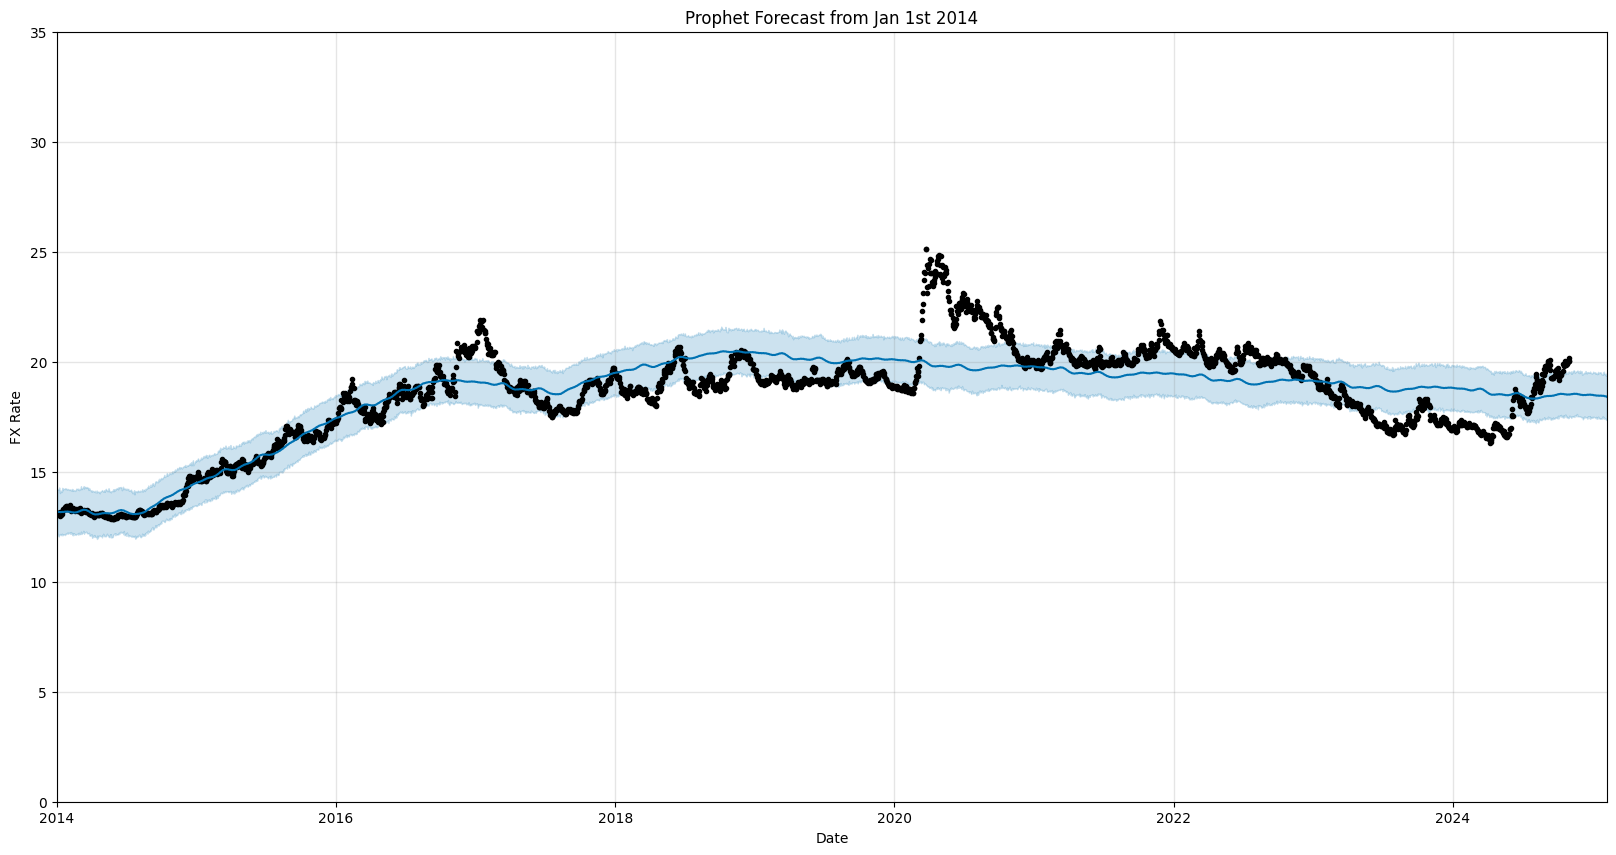

In [95]:
#Create a chart with a 10 year history to see whether it could be used as one of our final charts

#Create dataframe with data from begin Jan 2014
filtered_forecast = forecast_trends[forecast_trends['ds'] >= '2014-01-01']

start_date = mdates.datestr2num('2014-01-01')
end_date = filtered_forecast['ds'].iloc[-1]

fig, ax = plt.subplots(figsize=(20, 10))

model.plot(filtered_forecast, ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('FX Rate')
ax.set_title('Prophet Forecast from Jan 1st 2014')
ax.set_xlim([start_date, end_date])
ax.set_ylim(bottom=0, top=35)
plt.show()

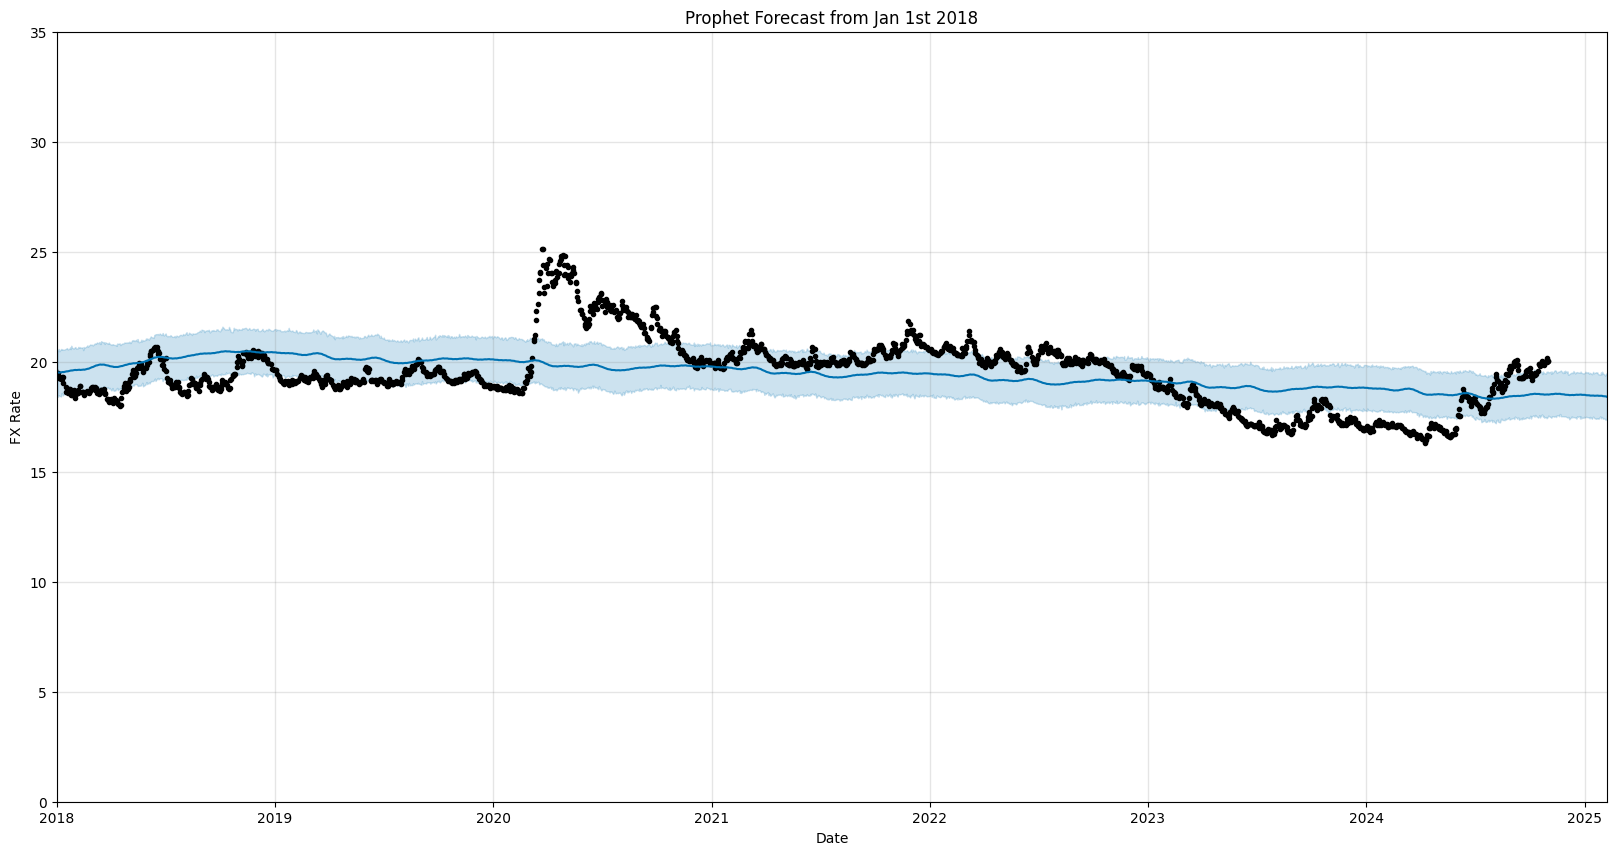

In [96]:
#Create a chart with a 7 year history to see whether it could be used as one of our final charts

#Create dataframe with data from begin Jan 2018
filtered_forecast = forecast_trends[forecast_trends['ds'] >= '2018-01-01']

start_date = mdates.datestr2num('2018-01-01')
end_date = filtered_forecast['ds'].iloc[-1]

fig, ax = plt.subplots(figsize=(20, 10))

model.plot(filtered_forecast, ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('FX Rate')
ax.set_title('Prophet Forecast from Jan 1st 2018')
ax.set_xlim([start_date, end_date])
ax.set_ylim(bottom=0, top=35)
plt.show()

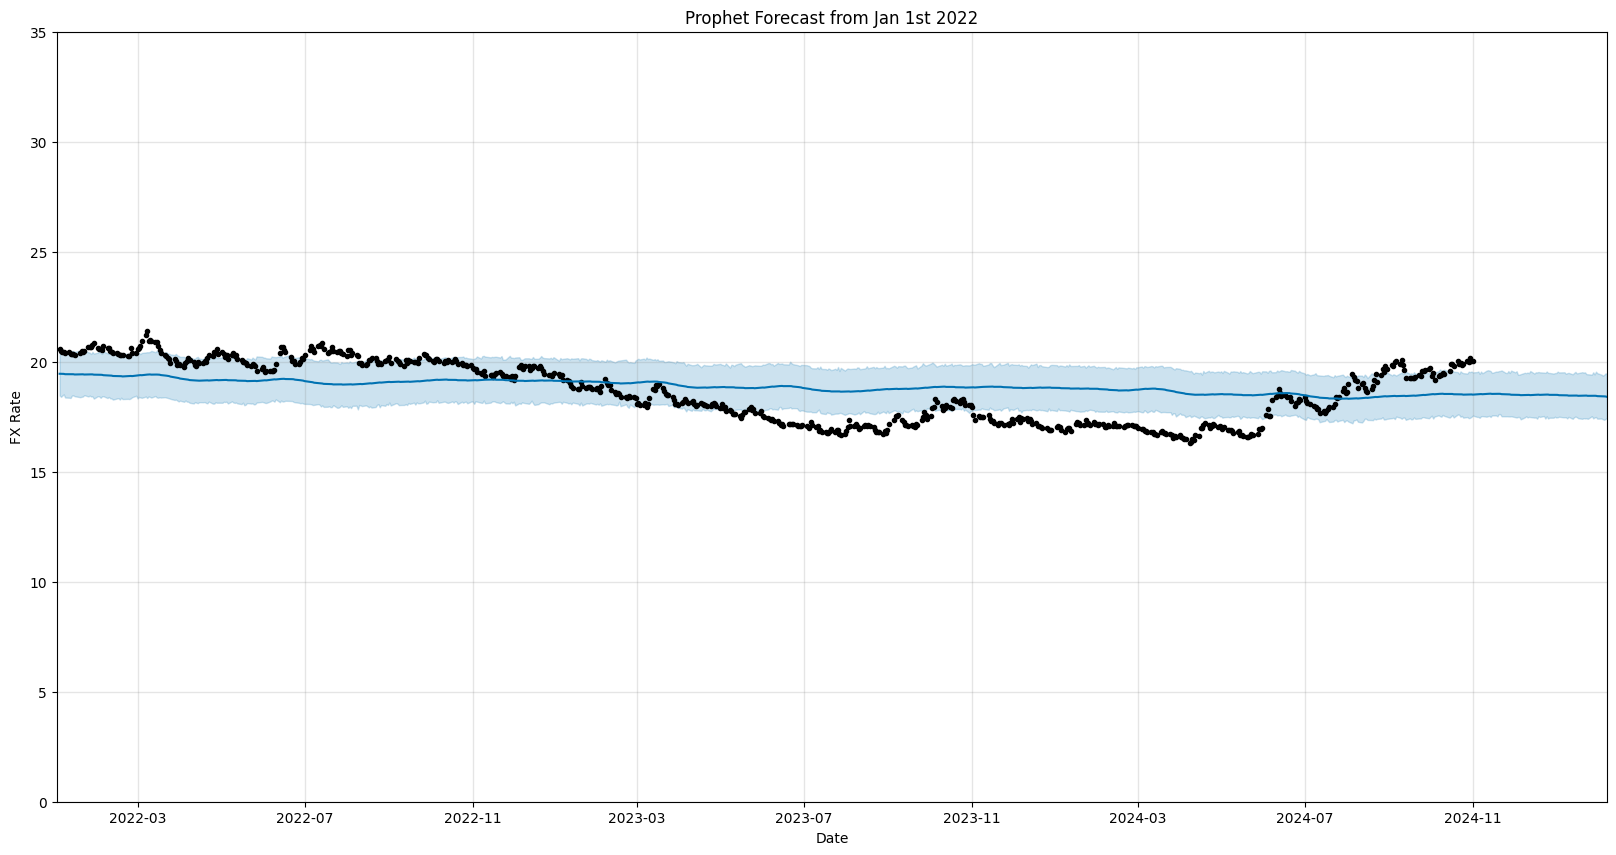

In [97]:
#Create a chart with a 3 year history to see whether it could be used as one of our final charts

#Create dataframe with data from begin Jan 2022
filtered_forecast = forecast_trends[forecast_trends['ds'] >= '2022-01-01']

start_date = mdates.datestr2num('2022-01-01')
end_date = filtered_forecast['ds'].iloc[-1]

fig, ax = plt.subplots(figsize=(20, 10))

model.plot(filtered_forecast, ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('FX Rate')
ax.set_title('Prophet Forecast from Jan 1st 2022')
ax.set_xlim([start_date, end_date])
ax.set_ylim(bottom=0, top=35)
plt.show()

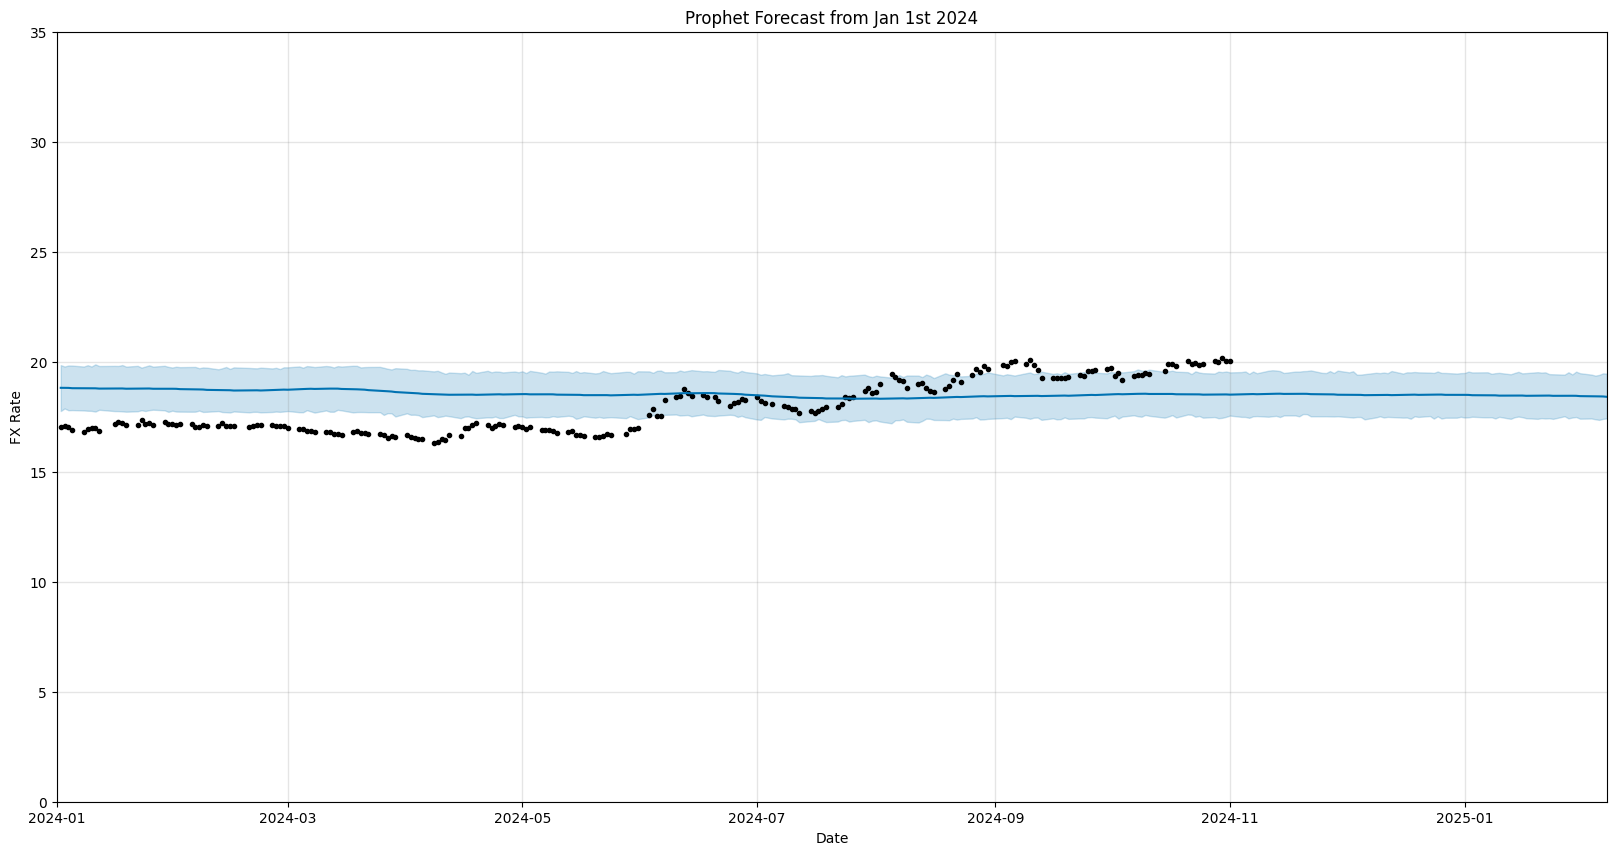

In [98]:
#Create a chart with a 1 year history to see whether it could be used as one of our final charts

#Create dataframe with data from begin Jan 2024
filtered_forecast = forecast_trends[forecast_trends['ds'] >= '2024-01-01']

start_date = mdates.datestr2num('2024-01-01')
end_date = filtered_forecast['ds'].iloc[-1]

fig, ax = plt.subplots(figsize=(20, 10))

model.plot(filtered_forecast, ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('FX Rate')
ax.set_title('Prophet Forecast from Jan 1st 2024')
ax.set_xlim([start_date, end_date])
ax.set_ylim(bottom=0, top=35)
plt.show()

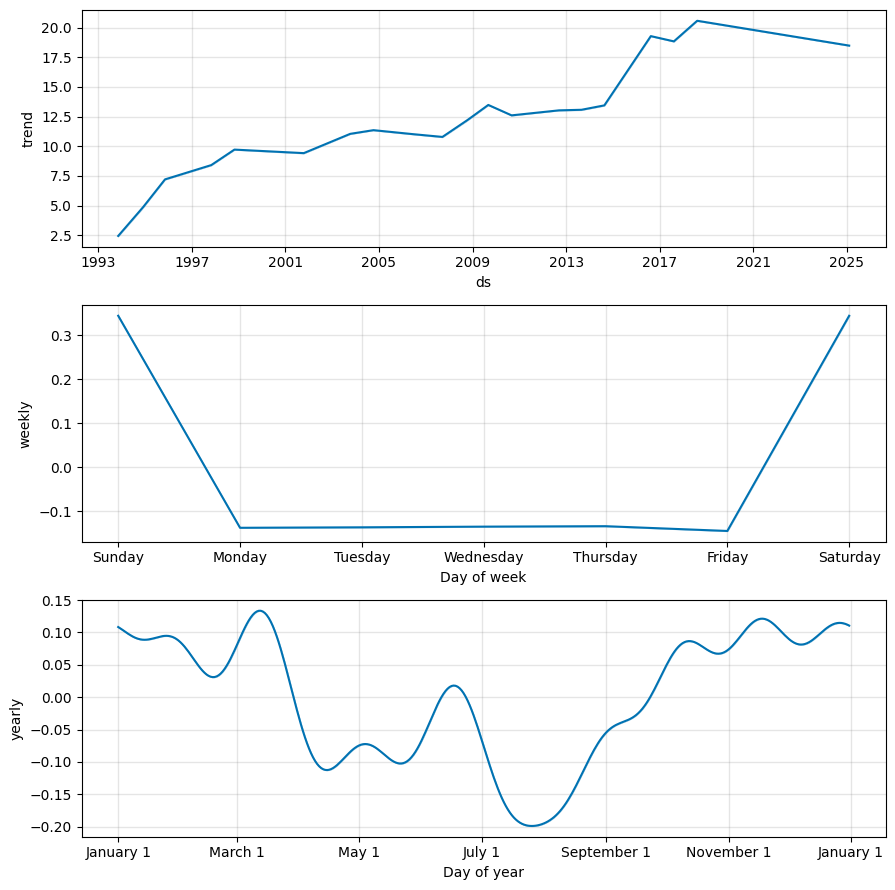

In [99]:
# Use the plot_components function to visualize the forecast results
figures = model.plot_components(forecast_trends)

In [100]:
# At this point, it's useful to set the `datetime` index of the forecast data.
forecast_trends = forecast_trends.set_index(["ds"])
forecast_trends.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
1993-11-08,2.441227,1.295466,3.393400,2.441227,2.441227,-0.038989,-0.038989,-0.038989,-0.137743,-0.137743,-0.137743,0.098754,0.098754,0.098754,0.0,0.0,0.0,2.402238
1993-11-09,2.447441,1.478243,3.476105,2.447441,2.447441,-0.034061,-0.034061,-0.034061,-0.136663,-0.136663,-0.136663,0.102602,0.102602,0.102602,0.0,0.0,0.0,2.413379
1993-11-10,2.453655,1.461168,3.420854,2.453655,2.453655,-0.028858,-0.028858,-0.028858,-0.135132,-0.135132,-0.135132,0.106274,0.106274,0.106274,0.0,0.0,0.0,2.424797
1993-11-12,2.466082,1.486861,3.473350,2.466082,2.466082,-0.032184,-0.032184,-0.032184,-0.144958,-0.144958,-0.144958,0.112774,0.112774,0.112774,0.0,0.0,0.0,2.433898
1993-11-15,2.484723,1.475697,3.474906,2.484723,2.484723,-0.018330,-0.018330,-0.018330,-0.137743,-0.137743,-0.137743,0.119413,0.119413,0.119413,0.0,0.0,0.0,2.466393


<Axes: xlabel='ds'>

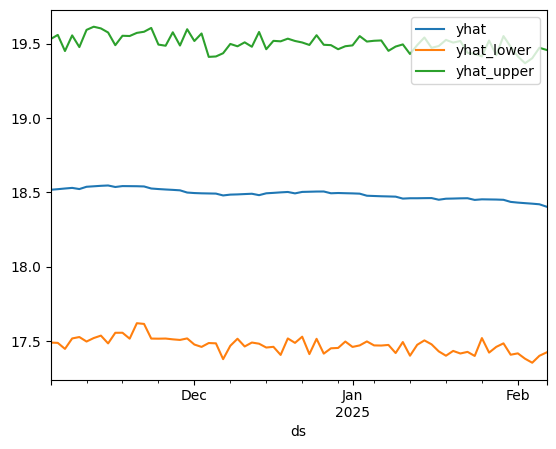

In [101]:
# From the `forecast_trends` DataFrame, plot to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 70 businesss days
forecast_trends[["yhat", "yhat_lower", "yhat_upper"]].iloc[-70:, :].plot()

In [102]:
# Create a DataFrame that contains just last 70 businesss days
forecast_90_days = forecast_trends.iloc[-70:, :][["yhat_upper", "yhat_lower", "yhat"]]

forecast_90_days = forecast_90_days.rename(
     columns={
        "yhat_upper": "Best Case",
        "yhat_lower": "Worst Case",
        "yhat": "Most Likely Case"
    }
)

# Review the last five rows of the DataFrame
forecast_90_days.head()

,Best Case,Worst Case,Most Likely Case
ds,,,
2024-11-04,19.529766,17.491979,18.517989
2024-11-05,19.557945,17.489672,18.521928
2024-11-06,19.449725,17.449356,18.526464
2024-11-07,19.554815,17.519465,18.530553
2024-11-08,19.476192,17.528953,18.522747


In [103]:
#Display the average price by month, so that index shows month name
forecast_90_days = forecast_90_days.groupby([forecast_90_days.index.year, forecast_90_days.index.month]).mean()

forecast_90_days

Best Case  Worst Case  Most Likely Case
ds   ds                                         
2024 11  19.546628   17.524745         18.529674
     12  19.495859   17.470628         18.494739
2025 1   19.488206   17.455041         18.462984
     2   19.422215   17.397583         18.421833